## Drive mount

In [1]:
# ------------------------------------------------------------
# Environment Setup: Google Drive Mounting
# ------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependency Installation

In [2]:
# ------------------------------------------------------------
# Dependency Installation
# ------------------------------------------------------------
# Install all required Python packages specified in requirements.txt.
# These dependencies are necessary for data generation, preprocessing,
# model training, and evaluation throughout the notebook.

%%capture
!pip install -r requirements.txt

## Path Configuration and Runtime Initialization

In [3]:
# ------------------------------------------------------------
# Path Configuration and Runtime Initialization
# ------------------------------------------------------------
from pathlib import Path

# Define the base working directory for this project
# Change the current working directory to the project root.
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/3학년 2학기/컴퓨터비전/TEAM_5")
%cd {BASE_DIR}

import sys
import torch

print('-' * 126)
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")

# Select GPU if available, else fallback to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

/content/drive/MyDrive/Colab Notebooks/3학년 2학기/컴퓨터비전/TEAM_5
------------------------------------------------------------------------------------------------------------------------------
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.9.0+cu126
Device: cpu


## Importing Project-Specific Modules

In [4]:
# ------------------------------------------------------------
# Importing Project-Specific Modules
# ------------------------------------------------------------

# Data Generation
from src.data_generation import (
    generate_normals_for_objects,     # Generates N_*.npy normal maps from raw input data
    generate_anomalies_for_objects    # Produces A_*.npy and M_*.npy anomaly maps based on normals and raw images
)

# Data Preprocessing
from src.dataprep import NormalMapDataset   # Loads normal/anomaly data, resizes images, and converts them to tensors

# AutoEncoder Model (training / loading)
from src.autoencoder import (
    train_autoencoder,   # Training routine for the AutoEncoder architecture
    load_model           # Utility function for loading a pretrained AutoEncoder model
)

# Evaluation (AUROC computation / visualization)
from src.evaluation import (
    evaluate_model,      # Computes pixel-level AUROC for anomaly detection
    show_results         # Visualizes reconstruction outputs and anomaly score maps
)


## Data Directory Configuration

In [ ]:
# ------------------------------------------------------------
# Data Directory Configuration
# ------------------------------------------------------------
# This section defines the paths to the raw input data and initializes
# the directory structure required for storing processed normal maps
# and anomaly maps generated in subsequent preprocessing steps.

import os
import glob

# Path to the raw Diligent dataset.
RAW_DATA_DIR = "data/raw/diligent/pmsData"

# List of object subdirectories included in the dataset.
obj_list = [
    'ballPNG', 'catPNG', 'cowPNG', 'bearPNG', 'buddhaPNG',
    'gobletPNG', 'harvestPNG', 'pot1PNG', 'pot2PNG', 'readingPNG'
]

# Construct absolute paths for each object directory.
obj_dirs = [os.path.join(RAW_DATA_DIR, d) for d in obj_list]

# Directory to store generated normal maps (N_*.npy).
normal_dir = BASE_DIR / "data" / "processed" / "normals"
normal_dir.mkdir(parents=True, exist_ok=True)

# Directory to store anomaly data (A_*.npy and M_*.npy).
anomalies_dir = BASE_DIR / "data" / "processed" / "anomalies"
anomalies_dir.mkdir(parents=True, exist_ok=True)


## Data Generation

### 1) Normal Map Check (N_*.npy) and Generation if Missing

In [ ]:
# -------------------------------------------------------------------
# 1) Normal Map Check (N_*.npy) and Generation if Missing
# -------------------------------------------------------------------
normal_files = sorted(glob.glob(os.path.join(normal_dir, "N_*.npy")))

if len(normal_files) == 0:
    print("[Normal] No N_*.npy files found. Generating new normal maps...")
    generate_normals_for_objects(BASE_DIR, normal_dir, obj_list)
    normal_files = sorted(glob.glob(os.path.join(normal_dir, "N_*.npy")))
    print(f"[Normal] Generation completed: {len(normal_files)} files created.")
else:
    print(f"[Normal] Using existing normal maps: {len(normal_files)} files.")


[Normal] Using existing normal maps: 138 files.


### 2) Anomaly Data Check (A_*.npy, M_*.npy) and Generation if Missing

In [ ]:
# -------------------------------------------------------------------
# 2) Anomaly Data Check (A_*.npy, M_*.npy) and Generation if Missing
# -------------------------------------------------------------------
anom_A_files = sorted(glob.glob(os.path.join(anomalies_dir, "A_*.npy")))
anom_M_files = sorted(glob.glob(os.path.join(anomalies_dir, "M_*.npy")))

if len(anom_A_files) == 0 or len(anom_M_files) == 0:
    print("[Anomaly] No A_*.npy or M_*.npy files found. Generating new anomaly data...")
    generate_anomalies_for_objects(normal_dir, RAW_DATA_DIR, anomalies_dir)
    anom_A_files = sorted(glob.glob(os.path.join(anomalies_dir, "A_*.npy")))
    anom_M_files = sorted(glob.glob(os.path.join(anomalies_dir, "M_*.npy")))
    print(f"[Anomaly] Generation completed: A = {len(anom_A_files)}, M = {len(anom_M_files)}")
else:
    print(f"[Anomaly] Using existing anomaly data: A = {len(anom_A_files)}, M = {len(anom_M_files)}")


[Anomaly] Using existing anomaly data: A = 30, M = 30


## Dataset Initialization

In [ ]:
# -------------------------------------------------------------------
# Dataset Initialization
# -------------------------------------------------------------------
# The training dataset consists of normal maps (N_*.npy) without masks.
# The anomaly dataset contains anomaly maps (A_*.npy) accompanied by
# corresponding masks (M_*.npy), enabling supervised evaluation.

train_dataset = NormalMapDataset(
    data_dir=normal_dir,     # Directory containing N_*.npy normal maps
    prefix='N',              # Prefix identifying normal map files
    has_mask=False,          # Normal maps do not include masks
    size=(256, 256)          # Spatial resolution for input tensors
)

anom_dataset = NormalMapDataset(
    data_dir=anomalies_dir,  # Directory containing A_*.npy anomaly maps
    prefix='A',              # Prefix identifying anomaly map files
    has_mask=True,           # Anomaly samples provide masks (M_*.npy)
    size=(256, 256)          # Spatial resolution for input tensors
)


## Training Configuration

In [ ]:
# ---------------------------------------------------------
# Training Configuration
# ---------------------------------------------------------
# Set train_mode to True to train the model and save the checkpoint.
# Set train_mode to False to load a pretrained model from disk.
# ---------------------------------------------------------

train_mode = False   # Toggle between training and loading mode
model_path = 'checkpoints/autoencoder/best_model_epoch_100.pth'
# model_path = 'checkpoints/autoencoder/best_model_epoch_exo_1.pth'

if train_mode:
    print("🟢 Training mode: Starting model training...")
    model, device, best_val_loss = train_autoencoder(
        data_dir=train_dataset,
        learning_rate=5e-4,
        batch_size=8,
        epochs=100,
        val_split=0.2,
        num_workers=2,
        model_save_path=model_path,
        loss_fn="mse",
    )
    print(f"Training completed. Best validation loss: {best_val_loss}")

else:
    print("🔵 Load mode: Loading pretrained model...")
    model, device = load_model(model_path)
    print("Model successfully loaded.")


🔵 Load mode: Loading pretrained model...
[load_model] 모델 로드 완료: checkpoints/autoencoder/best_model_epoch_100.pth
[load_model] device: cpu
Model successfully loaded.


## Evaluation

In [ ]:
# -------------------------------------------------------------------
# Evaluation
# -------------------------------------------------------------------

# Directory for storing evaluation outputs.
results_dir = BASE_DIR / "results"

# Perform anomaly detection evaluation and gather visualization data.
auroc, vis_data = evaluate_model(
    model=model,
    dataset=anom_dataset,
    device=device,
    max_vis_samples=1,
    save_dir=results_dir
)

print(f"Pixel-level AUROC: {auroc:.4f}")


모든 결과 저장 완료!
Pixel-level AUROC: 0.9520


## Visualization

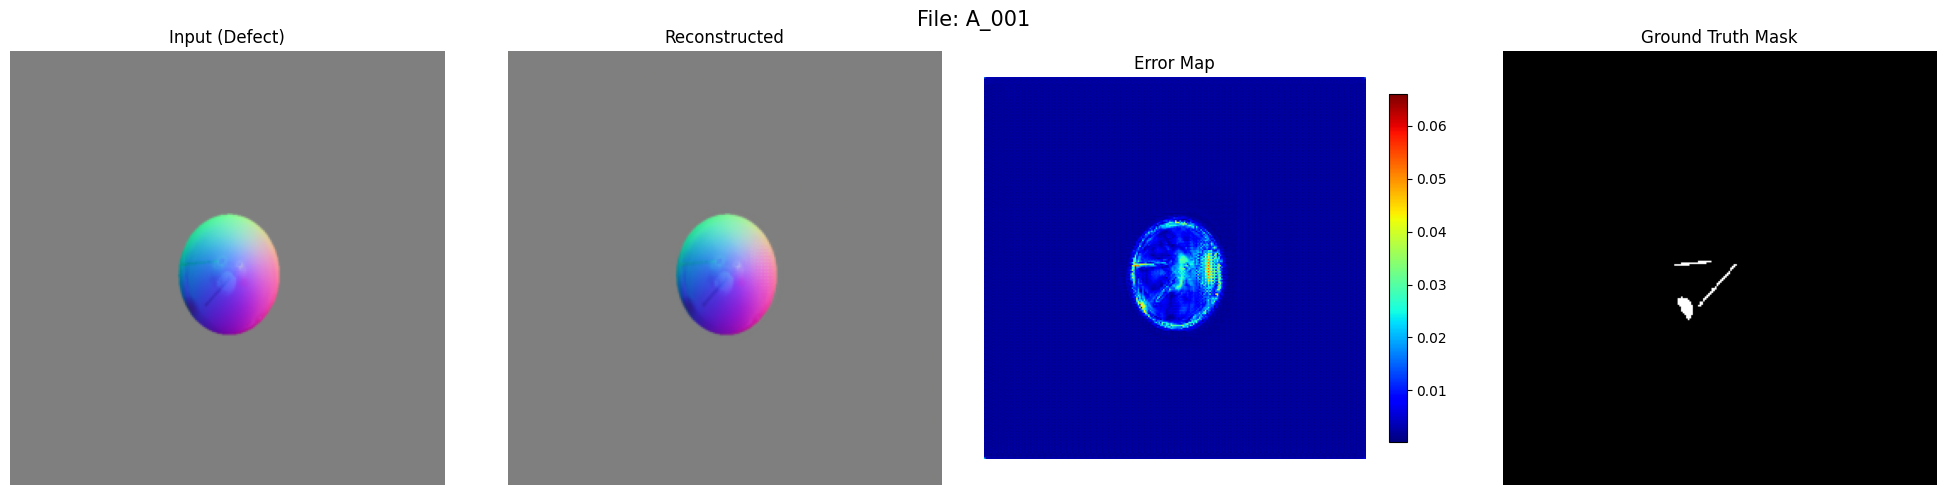

In [ ]:
# -------------------------------------------------------------------
# Visualization
# -------------------------------------------------------------------

# Display reconstruction results and anomaly score maps generated during evaluation.
show_results(vis_data)